# MNIST 데이터셋 불러오기

In [1]:
# MNIST 데이터셋을 내려받는 코드
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version = 1, as_frame = False)
mnist.keys()

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist['data'], mnist['target']

print(X.shape) # 이미지가 28 x 28 픽셀이기 때문에 784개의 특성 가짐
print(y.shape)

(70000, 784)
(70000,)


(784,)
(28, 28)


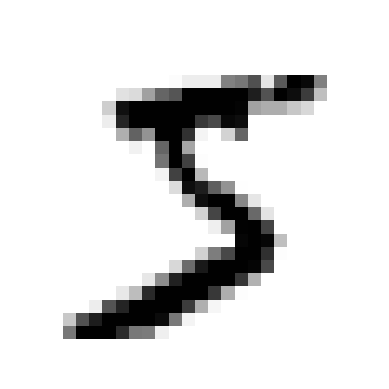

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
print(some_digit.shape)

some_digit_image = some_digit.reshape(28, 28)
print(some_digit_image.shape)

plt.imshow(some_digit_image, cmap = "binary")
plt.axis('off')
plt.show()

In [4]:
y[0]

'5'

In [5]:
import numpy as np

y = y.astype(np.uint8)

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# 5 이진 분류기 만들기
## SGDClassifier: 한 번에 하나씩 훈련 샘플을 독립적으로 처리하기 때문에 매우 큰 데이터셋을 효율적으로 처리하는 장점을 가지고 있음. 그렇기 때문에 온라인 학습에 잘 들어맞음.

In [7]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 32)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=32)

In [9]:
sgd_clf.predict([some_digit])

array([ True])

# 성능 측정

## 교차 검증을 사용한 정확도 측정

In [10]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = 'accuracy')

array([0.95175, 0.9636 , 0.952  ])

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits = 3, random_state = 42, shuffle = True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9543
0.96335
0.9685


In [12]:
from sklearn.base import BaseEstimator

class Never5Classfier(BaseEstimator):
    def fit(self, X, y = None):
        return self

    def predict(self, X):
        return np.zeros((len(X), 1), dtype = bool)

In [13]:
z = np.zeros((len(X), 1))

z.shape

(70000, 1)

In [14]:
never_5_clf = Never5Classfier()

cross_val_score(never_5_clf, X_train, y_train_5, cv = 3, scoring = 'accuracy')

array([0.91125, 0.90855, 0.90915])

## 오차 행렬

In [15]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

In [16]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[52728,  1851],
       [  802,  4619]])

In [17]:
y_train_perfect_predictons = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictons)

array([[54579,     0],
       [    0,  5421]])

In [18]:
from sklearn.metrics import precision_score
precision_score(y_train_5, y_train_pred)

0.7139103554868624

In [19]:
from sklearn.metrics import recall_score
recall_score(y_train_5, y_train_pred)

0.852056816085593

In [20]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7768900849381886

# 정밀도/재현율 트레이드오프

In [21]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([3519.0334845])

In [22]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [23]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [24]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method = 'decision_function')

In [25]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

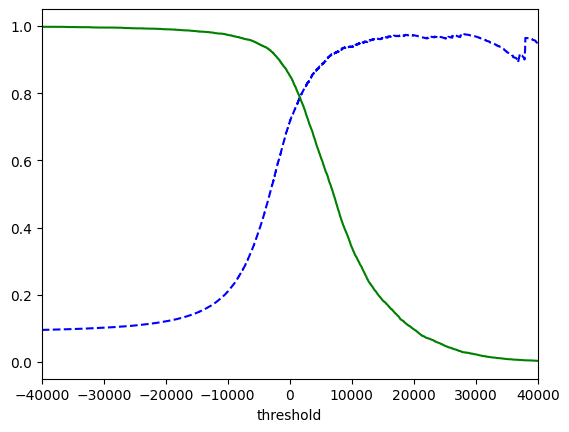

In [26]:
def plot_precision_vs_recall_for_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label = 'precision')
    plt.plot(thresholds, recalls[:-1], "g-", label = 'recall')
    plt.xlim(-40000, 40000)
    plt.xlabel('threshold')

plot_precision_vs_recall_for_threshold(precisions, recalls, thresholds)
plt.show()

In [27]:
threshold_90precision = thresholds[np.argmax(precisions >= 0.90)]
print(threshold_90precision)

5961.597918850829


In [28]:
y_train_pred_90 = (y_scores >= threshold_90precision)

In [29]:
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.9
0.5611510791366906


# ROC 곡선

In [30]:
from sklearn.metrics import roc_curve

fpr, tpr, threshold = roc_curve(y_train_5, y_scores)

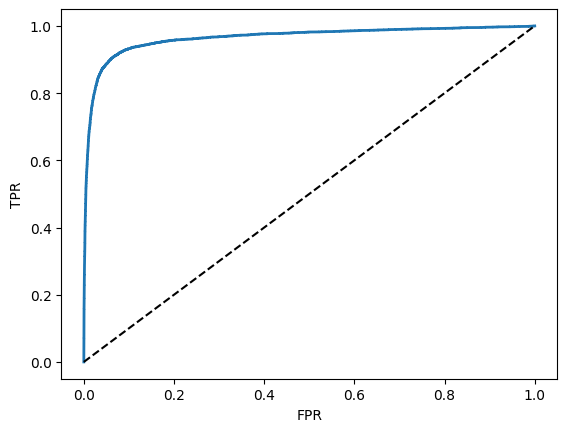

In [31]:
def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')

plot_roc_curve(fpr, tpr)
plt.show()

In [32]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9645672111368656

# RandomForestClassifier를 활용하고 ROC 곡선 구하기

In [33]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3, method = 'predict_proba')

In [34]:
y_scores_forest = y_probas_forest[:, 1]  # 양성 클래스에 대한 확률을 점수로 사용
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

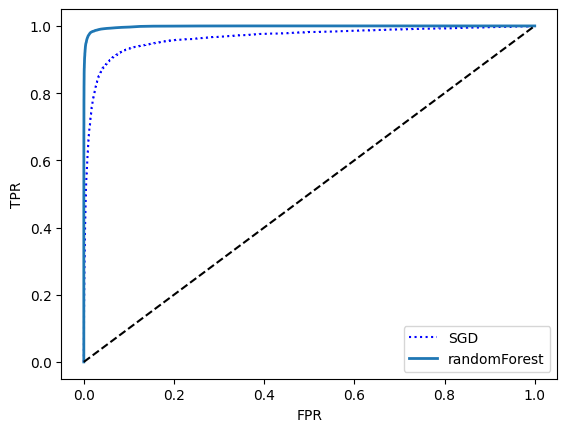

In [35]:
plt.plot(fpr, tpr, "b:", label = "SGD")
plot_roc_curve(fpr_forest, tpr_forest, "randomForest")
plt.legend(loc="lower right")
plt.show()

In [36]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

# 다중 분류

In [37]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [38]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [39]:
np.argmax(some_digit_scores)

5

In [40]:
svm_clf.classes_[5]

5

In [41]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [42]:
len(ovr_clf.estimators_)

10

In [43]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5], dtype=uint8)

In [46]:
sgd_clf.decision_function([some_digit])

array([[-15055.63624595, -20571.40795633,  -9696.22439148,
         -3363.11670381, -19533.09624628,    267.13969981,
        -19108.91904354, -12203.19309467, -16309.82039951,
        -10384.511989  ]])

In [47]:
cross_val_score(sgd_clf, X_train, y_train, cv = 3, scoring = "accuracy")

array([0.85365, 0.85045, 0.8831 ])

In [48]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv = 3, scoring = "accuracy")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


array([0.8993 , 0.88925, 0.90845])

# 에러 분석

In [49]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv = 3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


array([[5579,    0,   21,    6,    8,   48,   39,    6,  215,    1],
       [   0, 6403,   37,   25,    4,   44,    4,    7,  205,   13],
       [  27,   26, 5233,   92,   72,   27,   66,   36,  369,   10],
       [  23,   17,  117, 5240,    2,  209,   26,   40,  386,   71],
       [  12,   14,   42,   10, 5189,   13,   36,   26,  328,  172],
       [  27,   15,   29,  170,   52, 4485,   74,   15,  490,   64],
       [  29,   16,   46,    3,   43,   96, 5551,    4,  129,    1],
       [  20,    9,   51,   32,   50,   12,    3, 5699,  167,  222],
       [  19,   63,   44,   89,    3,  127,   26,   11, 5420,   49],
       [  21,   18,   30,   66,  121,   39,    1,  178,  334, 5141]])

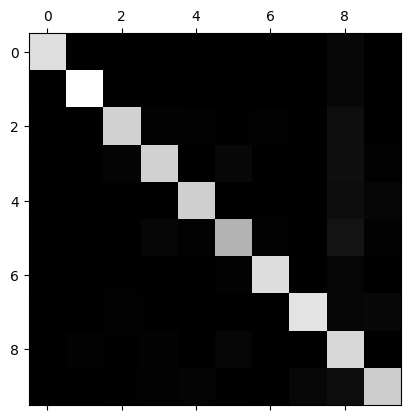

In [50]:
plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()

In [51]:
row_sums = conf_mx.sum(axis = 1, keepdims = True)
row_sums

array([[5923],
       [6742],
       [5958],
       [6131],
       [5842],
       [5421],
       [5918],
       [6265],
       [5851],
       [5949]])

In [52]:
norm_conf_mx = conf_mx / row_sums

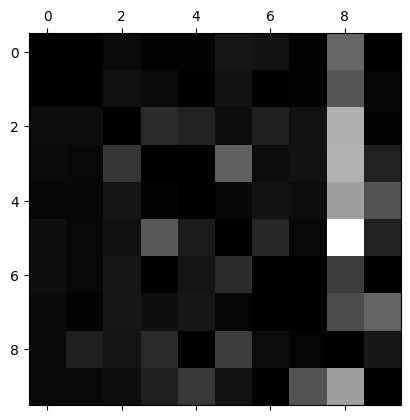

In [53]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()

In [55]:
# 그림 그리는 기능을 함수로 만들어두자.
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

# 숫자 그림을 위한 추가 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # n_rows = ceil(len(instances) / images_per_row) 와 동일합니다:
    n_rows = (len(instances) - 1) // images_per_row + 1

    # 필요하면 그리드 끝을 채우기 위해 빈 이미지를 추가합니다:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # 배열의 크기를 바꾸어 28×28 이미지를 담은 그리드로 구성합니다:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # 축 0(이미지 그리드의 수직축)과 2(이미지의 수직축)를 합치고 축 1과 3(두 수평축)을 합칩니다.
    # 먼저 transpose()를 사용해 결합하려는 축을 옆으로 이동한 다음 합칩니다:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # 하나의 큰 이미지를 얻었으므로 출력하면 됩니다:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

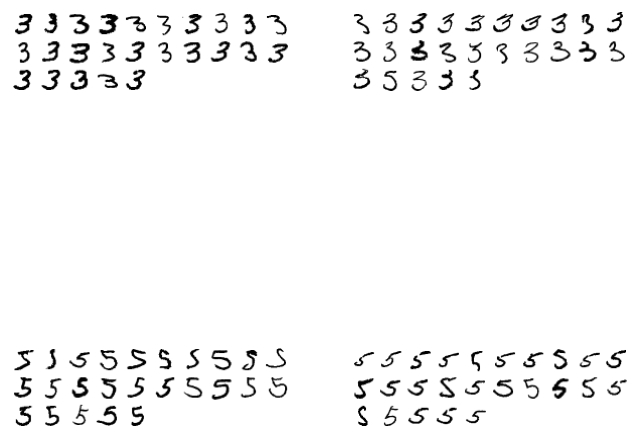

In [57]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize = (8, 8))
plt.subplot(221); plot_digits(X_aa[:25])
plt.subplot(222); plot_digits(X_ab[:25])
plt.subplot(223); plot_digits(X_ba[:25])
plt.subplot(224); plot_digits(X_bb[:25])
plt.show()

# 다중 레이블 분류

In [59]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [60]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [61]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv = 3)
f1_score(y_multilabel, y_train_knn_pred, average = "macro")

0.976410265560605

# 다중 출력 분류

In [63]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

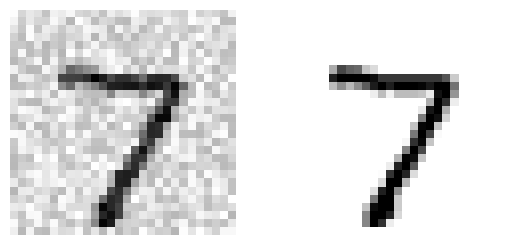

In [67]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])

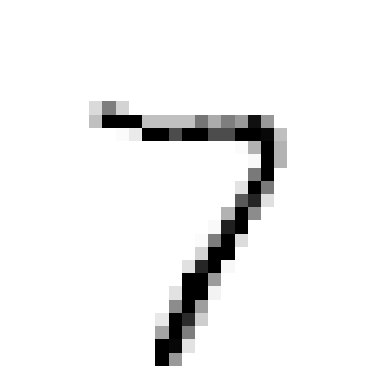

In [69]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)